# Introduction

This notebook illustrate a data science approach in an attempt to solve an SVG business problem. The data science approach I am following includes these steps,
 1. Business Understanding
 2. Analytics Approach
 3. Data Collection and Understanding
 4. Data Preparation
 5. Modeling and Evaluation
 6. Deployment
 7. Feedback

# 1. BUSINESS UNDERSTANDING

One aspect of our business involves calling potential customers (leads) who inquire about our products. In the best-case scenario, these customers work with our licensed sales agents to submit an application for a new policy (we consider this a sale). The typical structure this process takes is:

1.	We create a prediction score for all available uncontacted leads at the time of a match.
2.	The agent will match with the “best” uncontacted lead and call that lead.
3.	If the customer is not available, we put the lead back in the inventory of available leads for later consideration.  
4.	If the customer is available, the agent engages in a conversation; this is a contact.
5.	Agent assesses the customer’s interest and eligibility in our products.
6.	If applicable, the agent provides custom pricing information; this is a quote.
7.	If the customer is interested, the agent helps the customer submit an application.

Problem: How do we use available data to improve our prediction score (1) to maximize sales?



# 2. ANALYTICS APPROACH

To approach the solution, we can learn from the contacted leads and discover any trend that takes them to the applications. Once a lead’s information hit our database, we want to quickly identify of it could lead to an application. With such insight, SVG can take actions early to win the sales. 

This is a classification problem. We will try to predict the outcome of a lead to be either 0-non application or 1-application. The probability of this prediction should be included. This will help SVG to prioritize the list of customers to contact. 


# 3. DATA COLLECTION AND UNDERSTANDING

The provided dataset in csv form includes 26 columns and 147656 entries. These additional assumptions were also given,

●	Each observation in the provided data set is a single match event

●	Leads may be matched multiple times over their lifecycle

●	If a lead is contacted, it is removed from the inventory of available leads

Besides handling the invalid and uneccessary data, the above will also help massage the dataset further.

In [1]:
#Imports the neccessary packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#read the csv file and examine the first rows for the first glance
match_df = pd.read_csv('jds_project_data.csv',header = 0, delimiter = ',')
match_df.head()

,match_id,lead_id,agent_id,lead_source_id,lead_creation_date,matched_at,dial_count,source_type,state,gender,...,phone_type,email_score,email_valid,phone_score,contact_score,block_score,email_reason,contact,quote,app
0,40667,12289,174,8,1/19/2021 12:08,1/19/2021 12:43,1,DELIVERY,AR,Female,...,NaN,10.0,1.0,62,36.0,47.948863,0.0,0,0,0
1,144108,30625,176,83,1/22/2021 20:41,1/25/2021 16:03,2,FORM,MS,NaN,...,NaN,95.0,1.0,98,96.5,73.383948,0.0,0,0,0
2,4314,4446,91,50,1/17/2021 18:48,1/18/2021 9:25,3,DELIVERY,WI,Male,...,NaN,85.0,1.0,98,91.5,58.877858,0.0,0,0,0
3,89955,20851,228,15,1/20/2021 18:53,1/21/2021 11:17,4,DELIVERY,OK,Female,...,NaN,85.0,1.0,99,92.0,55.408187,0.0,0,0,0
4,77985,20544,168,109,1/20/2021 17:57,1/20/2021 17:57,0,FORM,WY,NaN,...,NaN,85.0,1.0,50,67.5,77.281536,0.0,0,0,0


In [2]:
#summarizing the data to see if there would be any missing data and to verify the data type
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147656 entries, 0 to 147655
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   match_id                 147656 non-null  int64  
 1   lead_id                  147656 non-null  int64  
 2   agent_id                 147656 non-null  int64  
 3   lead_source_id           147656 non-null  int64  
 4   lead_creation_date       147656 non-null  object 
 5   matched_at               147656 non-null  object 
 6   dial_count               147656 non-null  int64  
 7   source_type              147656 non-null  object 
 8   state                    147656 non-null  object 
 9   gender                   118781 non-null  object 
 10  age                      147656 non-null  int64  
 11  lead_cost                147656 non-null  float64
 12  result                   108572 non-null  float64
 13  lead_age_at_acquisition  106041 non-null  float64
 14  prep

# 4. DATA PREPARATION

# 4.1 Data Processing

With the assumptions and overall observations on the dataset, we can do the following to process our data,

- There are missing records in the 'gender' column. Simply removing these records not only reduce our data but also seems not practical. Customers sometimes do not share their genders. In addition, the method we obtained this record might not allow declaring the gender. Therefore, I will fill in these blanks with an 'Unidentified' label.

- With similar reason, I will also fill 'U'(Unidentified) for the blank 'prepaid phone' and 'Others' for the blank 'phone_in_service' columns.

- In the 'result' column, the blank records occupy a significant portion of the total records. Removing these will also significantly reduce our data. Therefore, I also fill in with 0 for now.

- For the 'lead_age_at_acquisition' column, if there is not a number for the missing record, I would treat it as a new record hence zero age. To avoid cutting valuable data, I will also fill in 0.

- The phone_type column doesn't have any record. We can drop it.

- If we notice, the contact_score column is the average of phone_core and email_score. So if we have these two scores, we can remove contact_score to avoid multicolinearity.

- The invalid data in the email_score and email_valid columns come together and there are very little number of them. We can drop these records.

- There are two columns with datetime format, 'lead_creation_date' and 'matched_at'. To make it easier to handle in the analysis, I will convert them into the numeric values. To to this, I will subtract the earliest date from each column and then convert the results into days. That will recreat two new columns 'lead_creation_del' and 'match_at_del'. We can use these two columns and drop the original datetime formated ones.

- Lastly, for this analysis, we want to analyze the contacted leads and model for the 'app' outcome. We know that an application will need at least contacted=1 and quote=1 . We aim to contact leads that has potential to convert to sales. Therefore, we don't have to keep the quote column. 

In [3]:
#fill the missing records in gender with 'Unidentified',
match_df.gender.fillna('Unidentified',inplace = True)

#fill the missing records in prepaid_phone with 'U'
match_df.prepaid_phone.fillna('U',inplace = True)

#fill the missing records in phone_in_service with 'Others'
match_df.phone_in_service.fillna('Others',inplace = True)

#fill the missing records in result with 0 for now
match_df.result.fillna(0,inplace = True)

#fill the missing records in lead_age_at_acquisition with 0 for now
match_df.lead_age_at_acquisition.fillna(0,inplace = True)

#dropping the phone type column
match_df=match_df.drop(columns ='phone_type')

#dropping the 'contact_score' column
match_df=match_df.drop(columns ='contact_score')

#dropping the NaN records in email_score and email_valid
match_df.dropna(inplace= True)

#handling datetime format
match_df['lead_creation_date'] = pd.to_datetime(match_df['lead_creation_date'],format="%m/%d/%Y %H:%M")
match_df['matched_at'] = pd.to_datetime(match_df['matched_at'],format="%m/%d/%Y %H:%M")

match_df['lead_creation_del']= (match_df['lead_creation_date']-min(match_df['lead_creation_date']))/np.timedelta64(1,'D')
match_df['matched_at_del']= (match_df['matched_at']-min(match_df['matched_at']))/np.timedelta64(1,'D')

match_df=match_df.drop(columns ='lead_creation_date')
match_df=match_df.drop(columns ='matched_at')

match_df=match_df.drop(columns ='quote')

match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147222 entries, 0 to 147655
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   match_id                 147222 non-null  int64  
 1   lead_id                  147222 non-null  int64  
 2   agent_id                 147222 non-null  int64  
 3   lead_source_id           147222 non-null  int64  
 4   dial_count               147222 non-null  int64  
 5   source_type              147222 non-null  object 
 6   state                    147222 non-null  object 
 7   gender                   147222 non-null  object 
 8   age                      147222 non-null  int64  
 9   lead_cost                147222 non-null  float64
 10  result                   147222 non-null  float64
 11  lead_age_at_acquisition  147222 non-null  float64
 12  prepaid_phone            147222 non-null  object 
 13  phone_in_service         147222 non-null  object 
 14  emai

As assumed, we have leads that have multiple contacts. In this analysis, we are not modeling the outcome of a match. We are only interested in early identifying if a lead will become a sale. Therefore, it makes sense if we have only one entry for each lead. We can create a new column 'match_count' to count all matches that have been made for each lead. Therefore, we will try to create such column and drop the previous matches associated with a 'lead_id'.

In [4]:
#leads with mutiple matches
match_df['match_count'] = match_df['lead_id'].map(match_df['lead_id'].value_counts())
match_df = match_df.sort_values(by = ['matched_at_del'])
match_df = match_df.drop_duplicates(keep='last',subset='lead_id')

match_df=match_df.drop(columns ='match_id')

Because the contacted leads will be removed from the inventory and we are trying to study these contacted lead, we will create a separate dataset for this purpose. We will analyze this contacted_df dataset to hopefully obtain some model. Then we will use the model to predict the outcome of uncontacted leads if we contact them.

In [5]:
contacted_df = match_df[match_df['contact'] == 1]
contacted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18233 entries, 130251 to 71345
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lead_id                  18233 non-null  int64  
 1   agent_id                 18233 non-null  int64  
 2   lead_source_id           18233 non-null  int64  
 3   dial_count               18233 non-null  int64  
 4   source_type              18233 non-null  object 
 5   state                    18233 non-null  object 
 6   gender                   18233 non-null  object 
 7   age                      18233 non-null  int64  
 8   lead_cost                18233 non-null  float64
 9   result                   18233 non-null  float64
 10  lead_age_at_acquisition  18233 non-null  float64
 11  prepaid_phone            18233 non-null  object 
 12  phone_in_service         18233 non-null  object 
 13  email_score              18233 non-null  float64
 14  email_valid      

# 4.2 Exploratory Data Analysis (EDA)

It is crutial to understand the data before modeling it. It can help us determine if the data representative enough to answer the business question in the first place. It will also tell us if additional data processing/cleaning is necessary. 

'app' is the outcome we are trying to predict. We will start the EDA with examing how the values are distributed. Running the code below shows us that the number of conversions is very small. This indicate that this dataset is not balanced.

In [6]:
contacted_df['app'].value_counts()

0    17225
1     1008
Name: app, dtype: int64

This dataset has both categorical data and numerical data. Different methodologies are applied to analyze them. Therefore, we will group the columns into two groups: categorical_predictors and numeric_predictors. 

In [7]:
categorical_predictors = ['agent_id','lead_source_id','source_type','state','gender','result',
                   'prepaid_phone','phone_in_service','email_valid','email_reason','contact']
numeric_predictors = ['lead_creation_del','matched_at_del','dial_count','age','lead_age_at_acquisition','lead_cost',
               'email_score','phone_score','block_score','match_count']

# 4.2.1 EDA for Categorical Data

Feature (agent_id)

226    175
93     154
232    151
219    148
244    145
      ... 
125     19
55      19
15      19
49      17
105     13
Name: agent_id, Length: 271, dtype: int64 

Feature (lead_source_id)

58     3388
29     3376
26      988
101     671
30      644
       ... 
78        1
51        1
74        1
70        1
54        1
Name: lead_source_id, Length: 111, dtype: int64 

Feature (source_type)

DELIVERY    15270
FORM         2963
Name: source_type, dtype: int64 

Feature (state)

TX    2072
IL    1136
NC     925
OH     876
MD     818
VA     808
PA     772
GA     749
WI     666
MI     631
AZ     625
TN     617
NJ     592
SC     582
AL     520
IA     505
IN     437
CO     409
OK     407
KY     375
MS     343
MO     330
KS     316
LA     309
OR     291
AR     256
NV     227
ID     224
NE     212
WV     208
MT     205
UT     191
WY     145
NH     128
DE     126
SD     101
ND      99
Name: state, dtype: int64 

Feature (gender)

Female          8686
Male            5917
Un

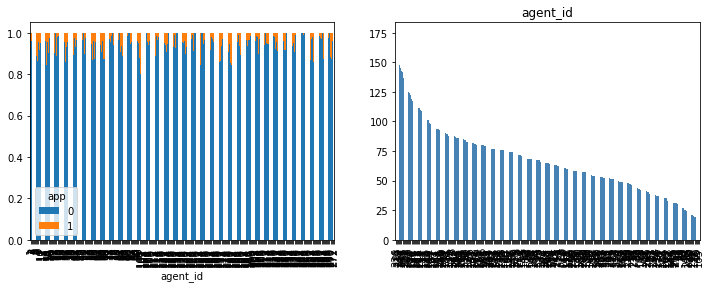

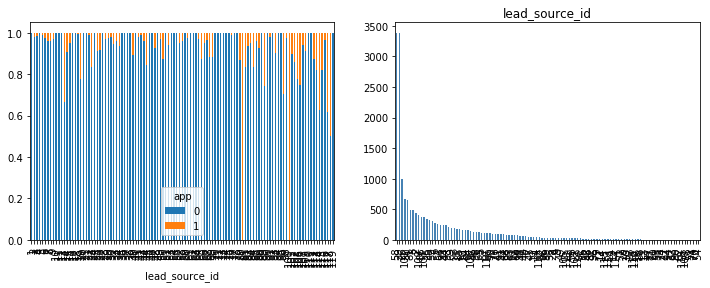

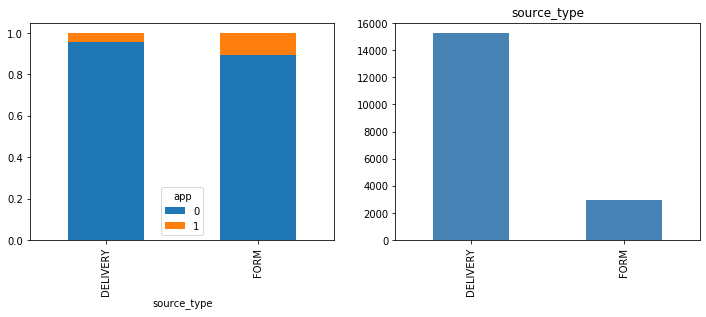

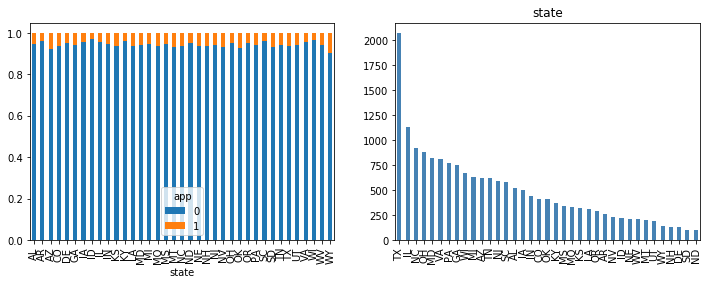

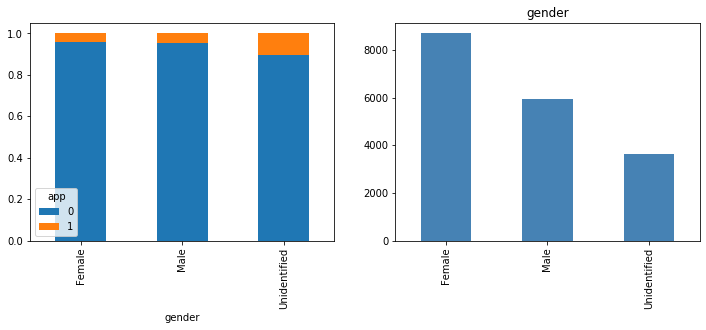

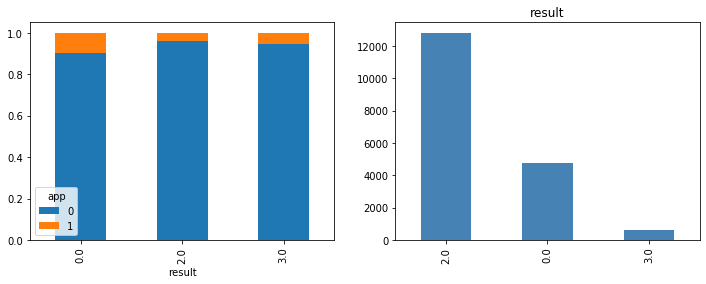

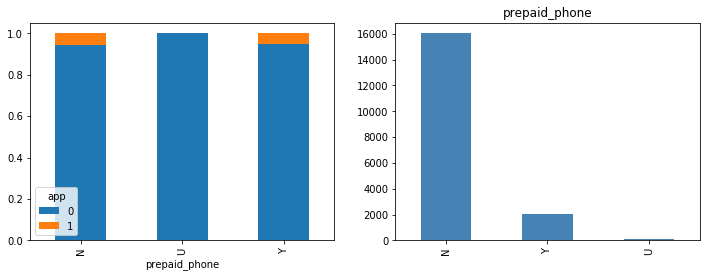

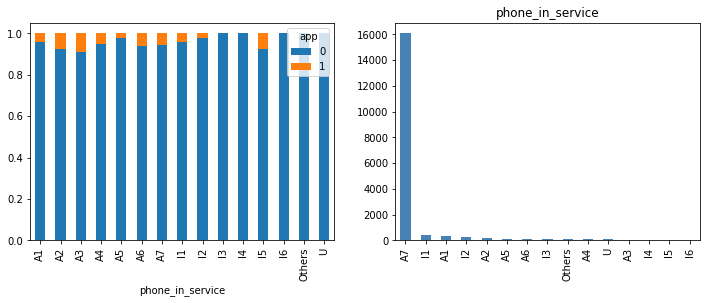

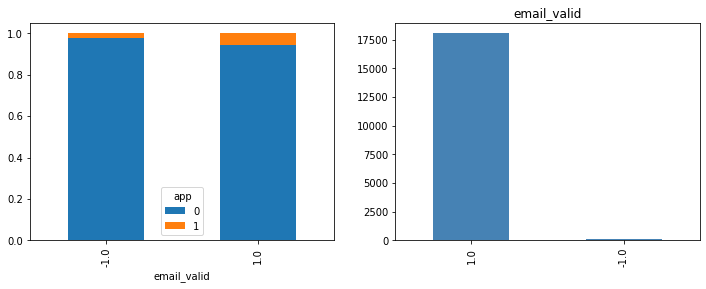

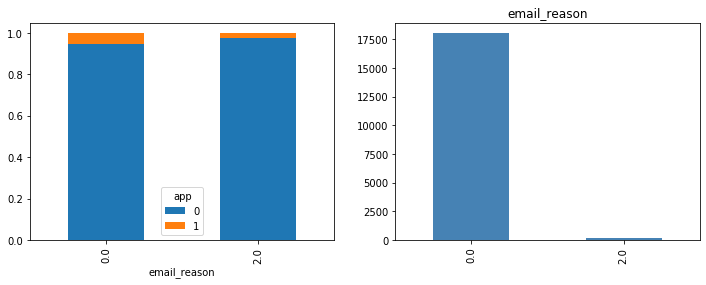

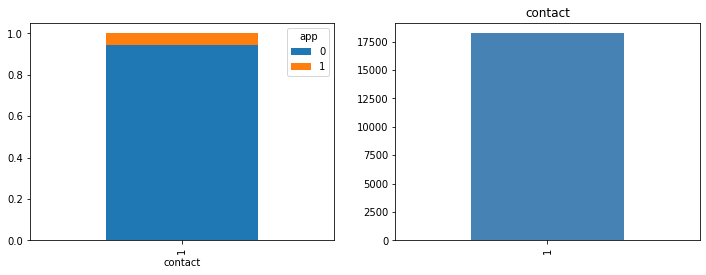

In [8]:
#for each categorical feature, we will see how 'app' distribute across them. 
#we will also see how each feature distribute within itself.
for attr in categorical_predictors:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  outcome_counts = contacted_df.groupby([attr, 'app']).size().rename('count').reset_index()
  by_outcome = outcome_counts.pivot(columns='app', values='count', index=attr)
  # Plot the proportions
  by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1);
  # Plot the counts
  contacted_df[attr].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue');
  print('Feature (%s)\n' % attr)
  print(contacted_df[attr].value_counts(), '\n')
  plt.title(attr)

- We see that there are agents who reached out to more leads than others. Some agents also brought in more applications than others.

- There are sources that resulted in more sales. There are sources that yielded significantly more sales. There are also sources that definitely made sales 100% at the times.

- In terms of sources_type, even though DELIVERY source has more records than FORM, it yielded significantly less favorable outcomes (sale). 

- We have more leads in Texas and Illinos but the sales seems to distribute all over the country. In fact, Wyoming is the state having the most sales though it has less leads. In other words, leads in this state seems to convert to sales more easily.

- We see that the 'Unidentified' genders has less entries but it has the most sales. This confirm that it was a wise decision to not drop these record in the data processing step earlier.

- Similarly, the result type of 0 has the most records of applications. This confirms that we should not drop the missing record in this column 'result'.


# 4.2.2 EDA for Numerical Data

We will first look at the general statistics of the numerical features

In [9]:
contacted_df[numeric_predictors].describe()

,lead_creation_del,matched_at_del,dial_count,age,lead_age_at_acquisition,lead_cost,email_score,phone_score,block_score,match_count
count,18233.000000,18233.000000,18233.000000,18233.000000,1.823300e+04,18233.000000,18233.000000,18233.000000,18233.000000,18233.000000
mean,26.275589,3.029824,1.075468,70.559699,3.321896e+03,25.720177,75.917019,83.485713,60.085464,2.061427
std,2.436602,2.340678,1.659604,7.658760,5.274794e+04,26.985038,20.370522,20.974350,10.093795,1.683900
min,20.829861,0.000000,0.000000,0.000000,0.000000e+00,0.010000,0.000000,0.000000,20.356337,1.000000
25%,24.665278,1.174306,0.000000,64.000000,0.000000e+00,5.070000,80.000000,70.000000,53.221203,1.000000
50%,25.921528,2.373611,0.000000,68.000000,1.824400e+00,18.510000,85.000000,98.000000,60.122714,1.000000
75%,27.791667,4.228472,2.000000,75.000000,6.302300e+00,40.000000,85.000000,99.000000,66.907748,2.000000
max,31.195139,7.582639,9.000000,121.000000,4.200010e+06,490.500000,95.000000,99.000000,99.363088,11.000000


Below we will go over the box plots to detect outliners for each feature. We see that there are quite a number of points seeming to be outliners in lead_age_at_acquisition. Diving deeper into this dataset and reviewing the statistics below, it looks like the records has the unit of seconds. Some leads has age of 86400 seconds which is a day old. So other than making the distribution skewed, these records would be identified as normal. We would keep them. 

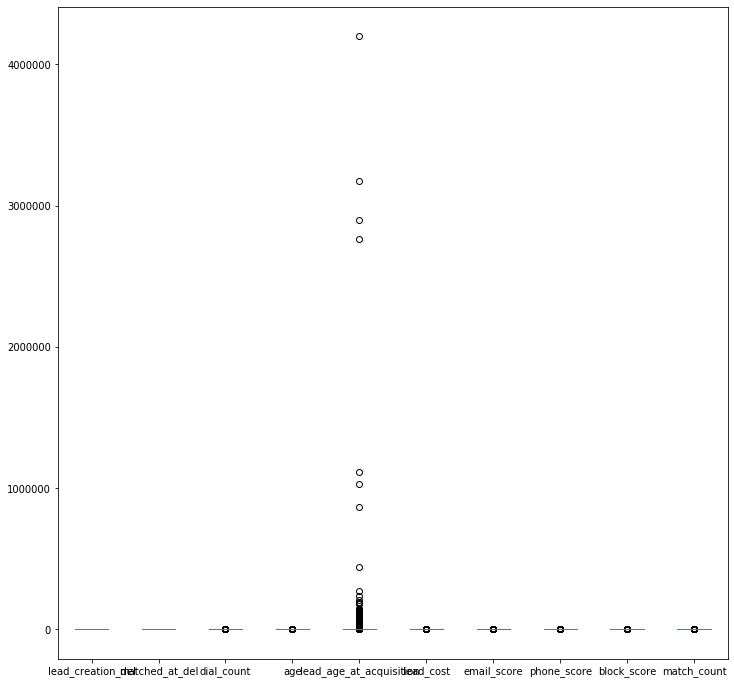

In [10]:
contacted_df[numeric_predictors].plot(kind = 'box', figsize = (12,12))

Next, we will plot the distribution of each numerical feature. We two distributions look similar, we may want to examine the correlation between them. Luckily we don't see similar distributions. We will confirm this further with the correlation matrix.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026A3DF447C8>,
      dtype=object)

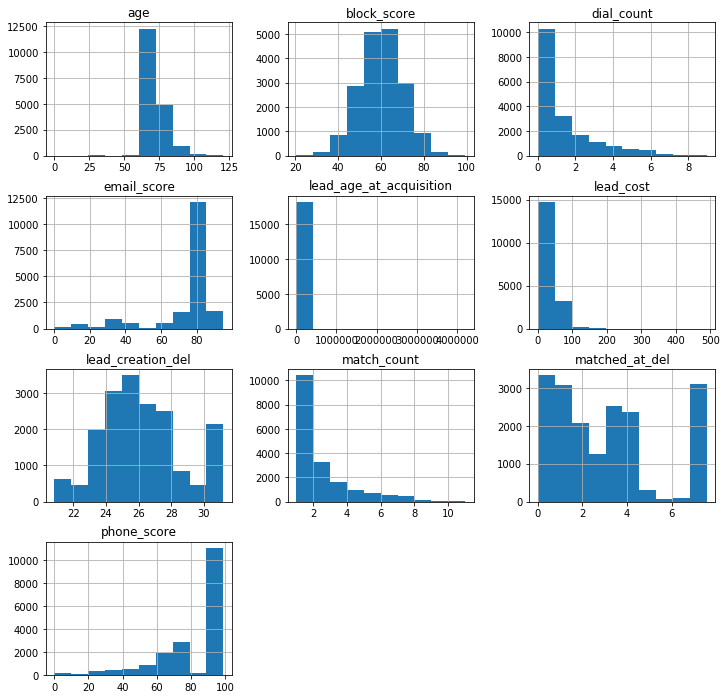

In [11]:
contacted_df[numeric_predictors].hist(figsize=(12,12))

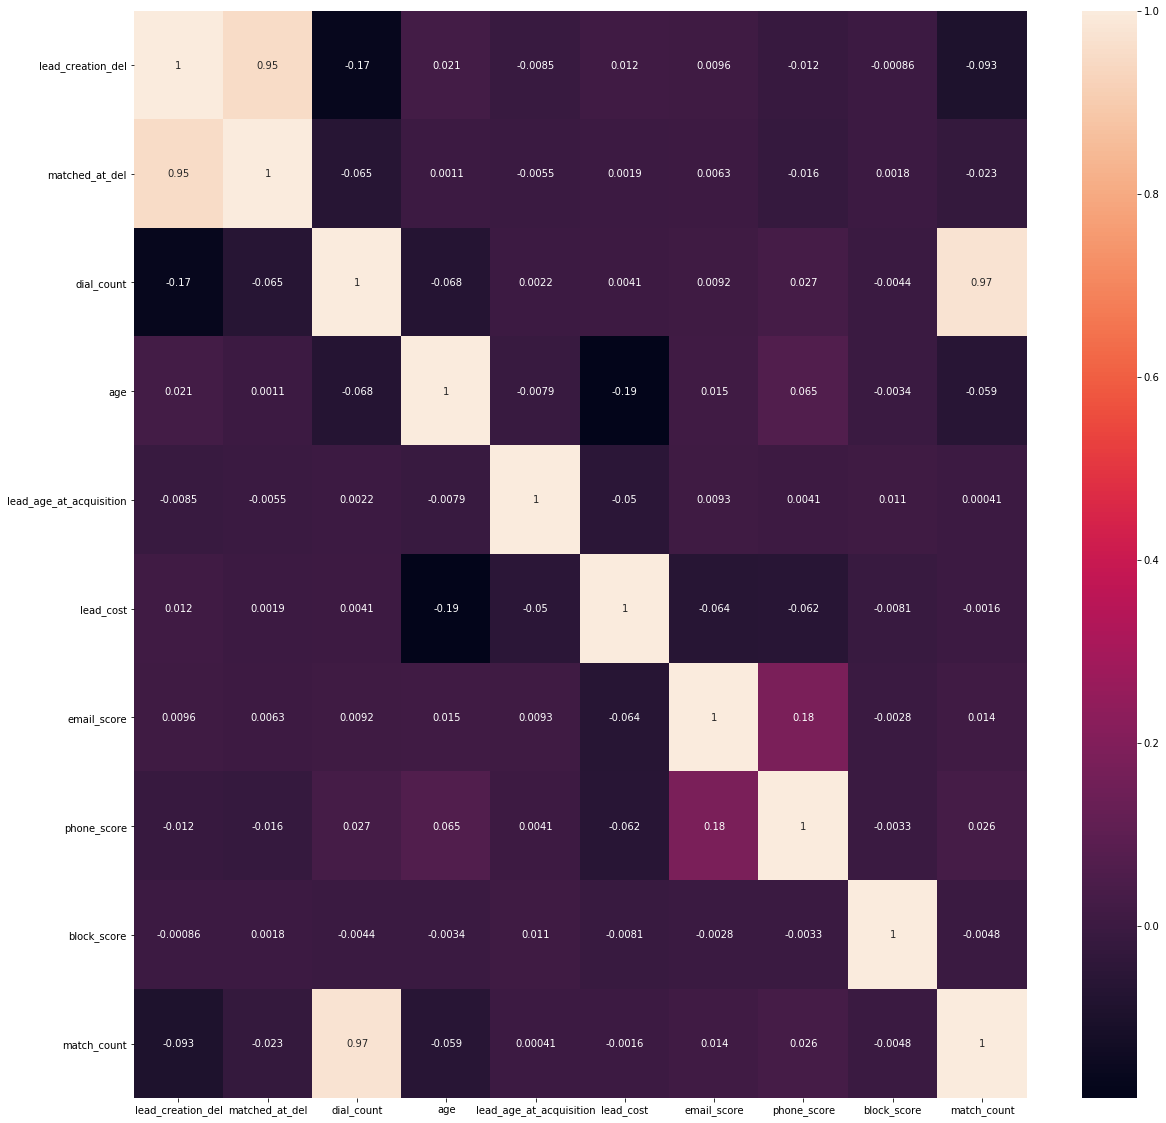

In [12]:
#Correlation Matrix
corrMatrix = contacted_df[numeric_predictors].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

# 4.3 Splitting Data to Train and Test

Here we will split data into training set and testing set with a ratio of 4:1. All predictors will be columns of the X dataset. We are trying to predict if a lead will eventually convert to a sale. Therefore, our y here will be 'app'. We will also set a random state for our split to make sure we can replicate the result.

In [13]:
#Creating varibales (X) and target (y) sets
from sklearn.model_selection import train_test_split
X = contacted_df.drop('app',axis=1)
y = contacted_df['app']

#Creating train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify= y,test_size=0.2,random_state=42)

print(f'Shape of X_train :{X_train.shape}')
print(f'Shape of X_test :{X_test.shape}')
print(f'Shape of y_train :{y_train.shape}')
print(f'Shape of y_test :{y_test.shape}')

Shape of X_train :(14586, 22)
Shape of X_test :(3647, 22)
Shape of y_train :(14586,)
Shape of y_test :(3647,)


# 4.4 Resampling

As discussed earlier, the dataset is not balanced. Referential resources and previous experience indicates that modeling unbalanced dataset can easily result in undesirable outcomes. We will need a technique to balance out the number of applications and non-applications. 

In this effot, downsampling is applied first. Due to limited computing power and time, if this resampling technique works, I will used the downsampled dataset to continue modeling. Other techniques will not be used if it's the case.

DOWNSAMPLING

In [14]:
#we will combine X_test and y_test to get ready for undersampling
X = pd.concat([X_train, y_train], axis=1)

#Seperate minority and majority class:
not_app = X[X['app'] == 0]
app = X[X['app'] == 1]
print(f'Total samples which are not application : {len(not_app)}')
print(f'Total applications : {len(app)}')

Total samples which are not application : 13780
Total applications : 806


In [15]:
# downsample majority
from sklearn.utils import resample
not_app_downsampled = resample(not_app,
                                replace = False, # sample without replacement
                                n_samples = len(app), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_app_downsampled, app])

# checking counts
downsampled.app.value_counts()

1    806
0    806
Name: app, dtype: int64

After downsampling, the dataset is balanced

In [16]:
downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 123409 to 142518
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lead_id                  1612 non-null   int64  
 1   agent_id                 1612 non-null   int64  
 2   lead_source_id           1612 non-null   int64  
 3   dial_count               1612 non-null   int64  
 4   source_type              1612 non-null   object 
 5   state                    1612 non-null   object 
 6   gender                   1612 non-null   object 
 7   age                      1612 non-null   int64  
 8   lead_cost                1612 non-null   float64
 9   result                   1612 non-null   float64
 10  lead_age_at_acquisition  1612 non-null   float64
 11  prepaid_phone            1612 non-null   object 
 12  phone_in_service         1612 non-null   object 
 13  email_score              1612 non-null   float64
 14  email_valid      

In [17]:
#Now we will split the training upsample into X_train and y_train
Xd_train = downsampled.drop('app',axis=1)
yd_train = downsampled['app']

After resampling, we would want to check if our distributions are significantly modified. If the features' distributions are distorted, the data we feed into the model may not reflex the data we hardly collected. In such situation, we teach the model some lessons that are not real. Therefore, it will not yield the accurate prediction. 

In this code below, we will define a function to plot the distributions of each numerical feature before and after downsampling. Red and Blue curves represent the distributions of app and non-app before downsampling. Pink and Cyan curves represent the distributions of app and non-app after downsampling.

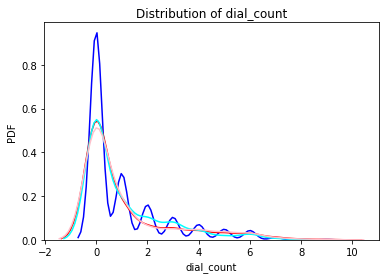

In [18]:
## We want to see how applications and non-applications distribute across the numerical features before and after 
## downsampling. Therefore, we will split the original contacts into app_trans and non_app_trans groups. 
## We will also split the same way for the downsampled set.
non_app_trans = contacted_df[contacted_df['app'] == 0]
app_trans = contacted_df[contacted_df['app'] == 1]
non_app_trans_down = downsampled[downsampled['app'] == 0]
app_trans_down = downsampled[downsampled['app'] == 1]


#define a 'compare_dist' function to plot the distribution of each features before and after downsampling.
def compare_dist(n_pr):
    sns.distplot(non_app_trans[n_pr], hist=False, kde=True, 
             bins=100, color = 'blue',
             hist_kws={'edgecolor':'black'})

    sns.distplot(app_trans[n_pr], hist=False, kde=True, 
             bins=100, color = 'red',
             hist_kws={'edgecolor':'black'})

    sns.distplot(non_app_trans_down[n_pr], hist=False, kde=True, 
             bins=100, color = 'cyan',
             hist_kws={'edgecolor':'black'})

    sns.distplot(app_trans_down[n_pr], hist=False, kde=True, 
             bins=100, color = 'pink',
             hist_kws={'edgecolor':'black'})
    # Add labels
    plt.title('Distribution of '+n_pr)
    plt.xlabel(n_pr)
    plt.ylabel('PDF')

    
compare_dist('dial_count')


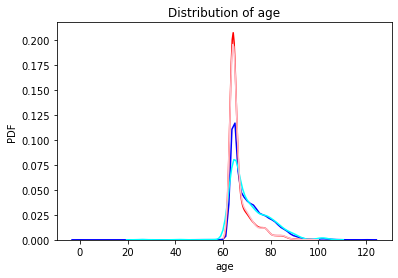

In [19]:
compare_dist('age')

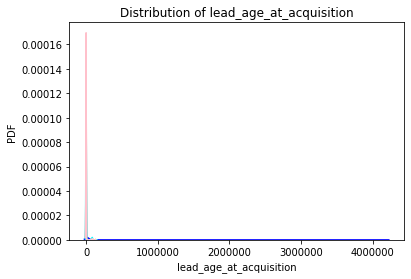

In [20]:
compare_dist('lead_age_at_acquisition')

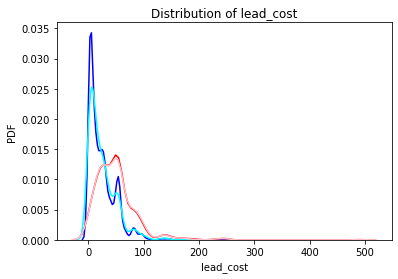

In [21]:
compare_dist('lead_cost')

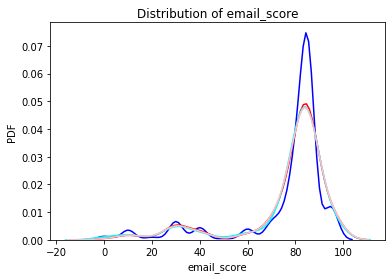

In [22]:
compare_dist('email_score')

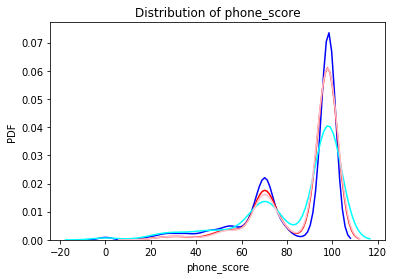

In [23]:
compare_dist('phone_score')

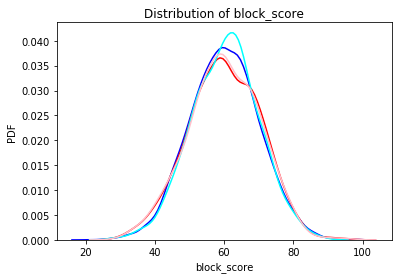

In [24]:
compare_dist('block_score')

We see that downsampling did not significantly modify the distributions of these feature. It seems to be a promising technique to handle unbalanced data in this situation.We will check further to see how the distributions look like across the categorical predictors.



For each categorical feature, we will generate a small report to quantitatively show how each categorical variable distribute. Then we will also visualize on plots to compare the categorical data before and after downsampling.

Feature (agent_id)

171    16
70     16
226    14
180    14
174    13
       ..
89      1
75      1
87      1
23      1
49      1
Name: agent_id, Length: 265, dtype: int64 

Feature (agent_id)

226    175
93     154
232    151
219    148
244    145
      ... 
125     19
55      19
15      19
49      17
105     13
Name: agent_id, Length: 271, dtype: int64 

Feature (lead_source_id)

58     280
29     214
26     100
101     84
81      83
      ... 
52       1
49       1
21       1
43       1
118      1
Name: lead_source_id, Length: 86, dtype: int64 

Feature (lead_source_id)

58     3388
29     3376
26      988
101     671
30      644
       ... 
78        1
51        1
74        1
70        1
54        1
Name: lead_source_id, Length: 111, dtype: int64 

Feature (source_type)

DELIVERY    1233
FORM         379
Name: source_type, dtype: int64 

Feature (source_type)

DELIVERY    15270
FORM         2963
Name: source_type, dtype: int64 

Feature (state)

TX    204
NC     92
IL     90
GA    

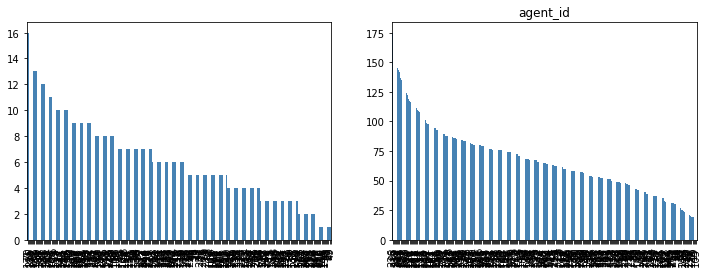

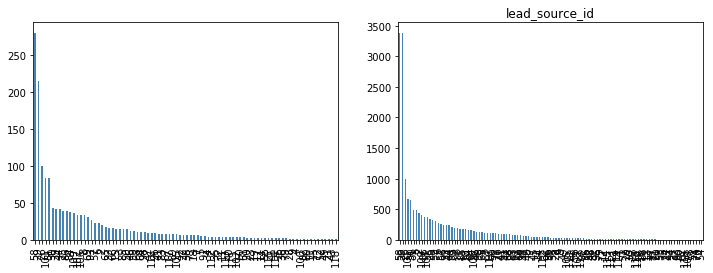

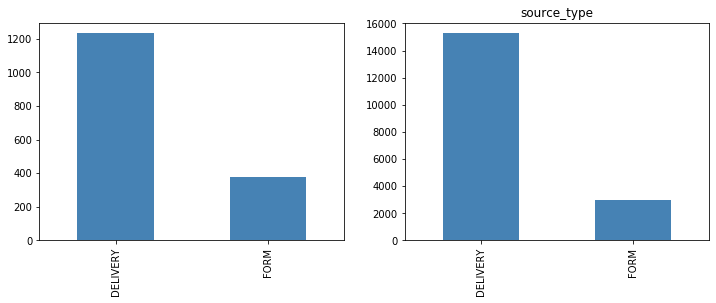

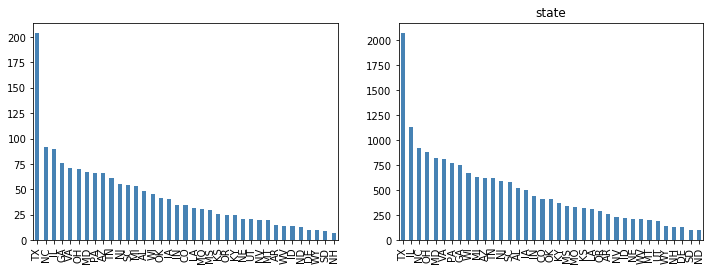

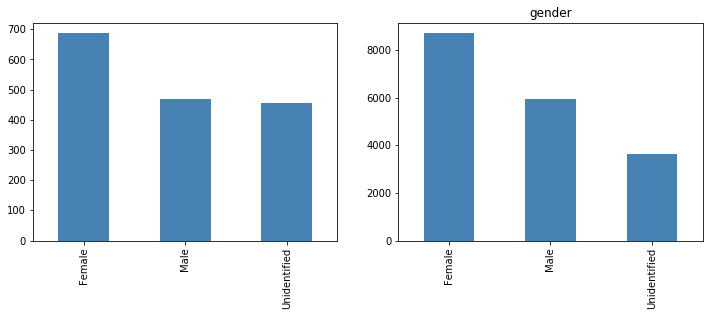

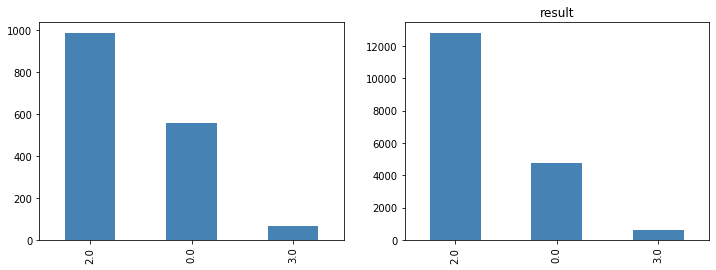

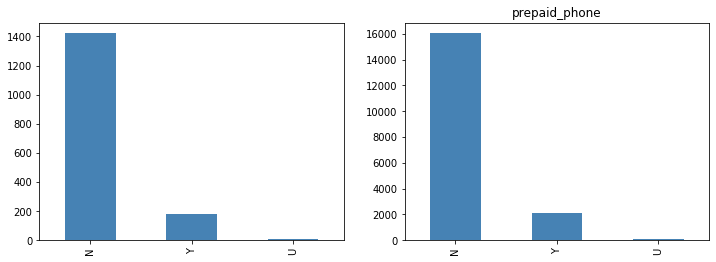

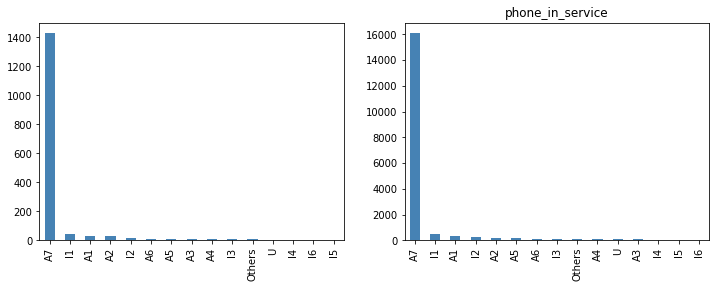

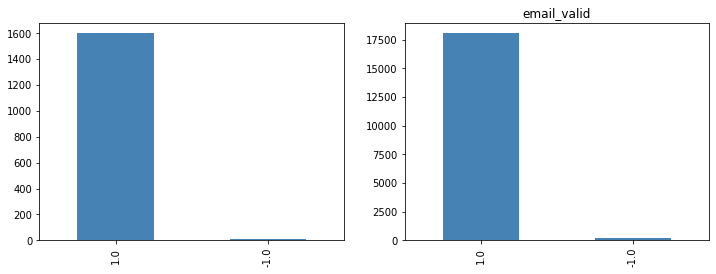

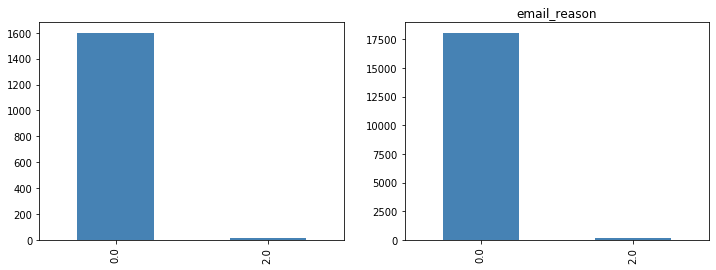

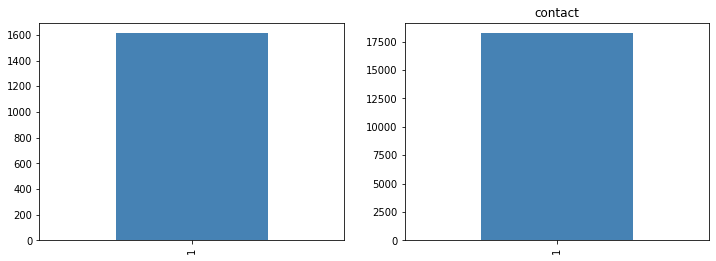

In [25]:
for attr in categorical_predictors:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4)) 
  # Plot the counts for down-sample
  downsampled[attr].value_counts().plot.bar(ax=ax1, legend=False,color='steelblue');
  print('Feature (%s)\n' % attr)
  print(downsampled[attr].value_counts(), '\n')
  plt.title(attr)
  # Plot the counts for original sample
  contacted_df[attr].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue');
  print('Feature (%s)\n' % attr)
  print(contacted_df[attr].value_counts(), '\n')
  plt.title(attr)

We see that the before and after distributions look very similar. Therefore, downsampling has successfully handle the unbalance within the dataset. We can use the downsampled data for modeling.

# 5. Modeling

# 5.1 Label Encoder

As the algorithms will need the string labels to be encoded, we will need to write some function to label encode the columns with object type. 

In [26]:
#label encoder
from sklearn import preprocessing    
def convert(data):
    for column in downsampled.columns:
        if downsampled[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            downsampled[column] = le.fit_transform(downsampled[column])
            
convert(downsampled)

def convert_2(data):
    for column in X_test.columns:
        if X_test[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            X_test[column] = le.fit_transform(X_test[column])       
            
convert_2(X_test)

def convert_3(data):
    for column in Xd_train.columns:
        if Xd_train[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            Xd_train[column] = le.fit_transform(Xd_train[column])
convert_3(Xd_train)
#X_test.info()
#Xd_train.info()
#test_set = convert(pd.concat([X_test, y_test], axis=1))
#test_set.info()
#X_test = test_set.drop('app',axis=1)
#y_test = test-set_df['app']

# 5.2 Importing packages and create instances for the algorithms

We will attempt constructing base models with 5 algorithms for this class: Logistics Regression (lr), Random Forest (rf), k Nearest Neighbor (knn), Gradient Bossting Classifier (gb) and Support Vector Machine (svc). We will use scores in confusion matrix and ROC curve to choose the best algorithm to model the outcome 'app'. We want to accurately predict as many app = 1 as possible. We would also want to watch out for any true app = 0 being misclassified as 1. Therefore, we aim to maximize true positive and minimize false positve. Currently, the scoring functions in cross-validation only return a single avalue. We will need to write a scorer to return a confusion matrix within the cross-validation.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import f1_score,classification_report,recall_score, accuracy_score

#create instance for each algorithm
lr_down = LogisticRegression()
rf_down = RandomForestClassifier()
knn_down = KNeighborsClassifier(n_neighbors=3)
gb_down = GradientBoostingClassifier(random_state =0)
svc_down= SVC()

#Currently only those scorer functions that return a single score can be passed inside the dict. 
#Scorer functions that return multiple values are not permitted and will require a wrapper to 
#return a single metric:

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def rc(y_true, y_pred): return recall_score(y_true, y_pred)
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn),
           'rc': make_scorer(rc)}

# 5.3 Fitting and Cross Validation for Base Models

We will fit each algorithm with the downsampled training dataset. We use stratified k-fold of 5 for cross validation. At the end of each cross-validation, we will print out the False Negative and Recall Scores for each fold.

5.3.1 Logistic Regression: Fitting and validating

In [28]:
#cross validating logictics regression

lrdown_cv_results = cross_validate(lr_down.fit(Xd_train, yd_train), Xd_train, yd_train, cv=5, 
                                 scoring=scoring)

# Getting the test set false negative scores
print('Logictic regression FN scores:',lrdown_cv_results['test_fn'])

# Getting the test set f1 scores
print('Logictic regression recall scores:',lrdown_cv_results['test_rc'])

Logictic regression FN scores: [48 56 68 48 54]
Logictic regression recall scores: [0.70186335 0.65432099 0.57763975 0.70186335 0.66459627]


C:\Users\17138\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\17138\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

5.3.2 Random Forest: Fitting and Validating

In [29]:
#cross validating random forest

rfdown_cv_results = cross_validate(rf_down.fit(Xd_train, yd_train), Xd_train, yd_train, cv=5, 
                                 scoring=scoring)

# Getting the test set false negative scores
print('Random forest FN scores:',rfdown_cv_results['test_fn'])

# Getting the test set f1 scores
print('Random forest recall scores:',rfdown_cv_results['test_rc'])

Random forest FN scores: [40 40 52 42 45]
Random forest recall scores: [0.7515528  0.75308642 0.67701863 0.73913043 0.72049689]


5.3.3 K Nearest Neighbors: Fitting and Validating

In [30]:
#cross validating knn

knndown_cv_results = cross_validate(knn_down.fit(Xd_train, yd_train), Xd_train, yd_train, cv=5, 
                                 scoring=scoring)

# Getting the test set false negative scores
print('KNN FN scores:',knndown_cv_results['test_fn'])

# Getting the test set f1 scores
print('KNN forest recall scores:',knndown_cv_results['test_rc'])

KNN FN scores: [75 82 77 89 82]
KNN forest recall scores: [0.53416149 0.49382716 0.52173913 0.44720497 0.49068323]


5.3.4 Gradient Boosting: Fitting and Validating

In [31]:
#cross validate gradient boosting

gbdown_cv_results = cross_validate(gb_down.fit(Xd_train, yd_train), Xd_train, yd_train, cv=5, 
                                 scoring=scoring)

# Getting the test set false negative scores
print('Gradient Boosting FN scores:',gbdown_cv_results['test_fn'])

# Getting the test set f1 scores
print('Gradient Boosting recall scores:',gbdown_cv_results['test_rc'])

Gradient Boosting FN scores: [34 48 46 36 41]
Gradient Boosting recall scores: [0.78881988 0.7037037  0.71428571 0.77639752 0.74534161]


5.3.5 Support Vector Machine: Fitting and Validating

In [32]:
#cross validate support vector machine
svcdown_cv_results = cross_validate(svc_down.fit(Xd_train, yd_train), Xd_train, yd_train, cv=5, 
                                 scoring=scoring)

# Getting the test set false negative scores
print('Support Vector Machine FN scores:',svcdown_cv_results['test_fn'])

# Getting the test set f1 scores
print('Support Vector Machine recall scores:',svcdown_cv_results['test_rc'])

Support Vector Machine FN scores: [105 117 109  94   2]
Support Vector Machine recall scores: [0.34782609 0.27777778 0.32298137 0.41614907 0.98757764]


# 5.4 Base Model Review

For each fitted model, we will pull its parameters, plot the ROC curve, compute the area under the curve and visualize the confusion matrix

In [33]:
#making predictions

lrdown_pred = lr_down.predict(X_test)
rfdown_pred = rf_down.predict(X_test)
knndown_pred= knn_down.predict(X_test)
gbdown_pred= gb_down.predict(X_test)
svcdown_pred= svc_down.predict(X_test)

5.4.1 Logistics Regression Base Model

In [34]:
lr_down.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

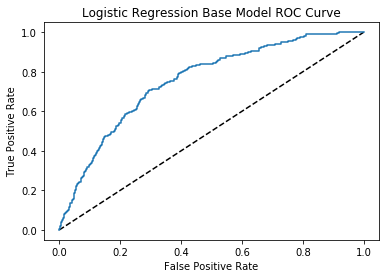

In [35]:
#ROC curve for Logistic Regression Base Model

from sklearn.metrics import roc_curve 
y_lrdown_pred_prob = lr_down.predict_proba(X_test)[:,1] 
fpr, tpr, thresholds = roc_curve(y_test, y_lrdown_pred_prob) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.plot(fpr, tpr, label='Logistic Regression') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Logistic Regression Base Model ROC Curve') 
plt.show(); 

In [36]:
#Area under the curve

from sklearn.metrics import roc_auc_score 
roc_auc_score(y_test, y_lrdown_pred_prob)

0.7548578079868944

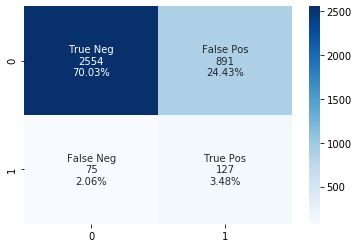

In [37]:
#Base model LR Confusion Matrix
lrdown_cf_matrix_base = confusion_matrix(y_test, lrdown_pred)
#heatmap Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                lrdown_cf_matrix_base.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     lrdown_cf_matrix_base.flatten()/np.sum(lrdown_cf_matrix_base)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lrdown_cf_matrix_base, annot=labels, fmt='', cmap='Blues')

5.4.2 Random Forest Base Model

In [38]:
rf_down.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

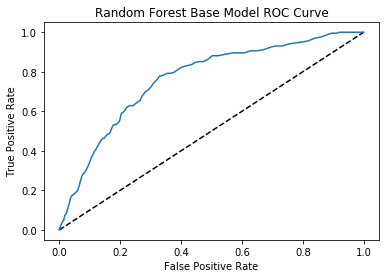

In [39]:
#ROC curve for Random Forest Base Model

from sklearn.metrics import roc_curve 
y_rfdown_pred_prob = rf_down.predict_proba(X_test)[:,1] 
fpr, tpr, thresholds = roc_curve(y_test, y_rfdown_pred_prob) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.plot(fpr, tpr, label='Logistic Regression') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Random Forest Base Model ROC Curve') 
plt.show(); 

In [40]:
#Area under the curve

from sklearn.metrics import roc_auc_score 
roc_auc_score(y_test, y_rfdown_pred_prob)

0.7629941513744988

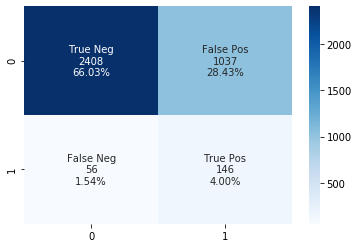

In [41]:
#Base model RF Confusion Matrix
rfdown_cf_matrix_base = confusion_matrix(y_test, rfdown_pred)
#heatmap Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                rfdown_cf_matrix_base.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     rfdown_cf_matrix_base.flatten()/np.sum(rfdown_cf_matrix_base)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rfdown_cf_matrix_base, annot=labels, fmt='', cmap='Blues')

5.4.3 KNN Base Model

In [42]:
knn_down.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

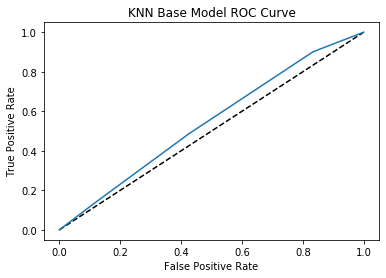

In [43]:
#ROC curve for KNN Base Model

from sklearn.metrics import roc_curve 
y_knndown_pred_prob = knn_down.predict_proba(X_test)[:,1] 
fpr, tpr, thresholds = roc_curve(y_test, y_knndown_pred_prob) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.plot(fpr, tpr, label='Logistic Regression') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('KNN Base Model ROC Curve') 
plt.show(); 

In [44]:
#Area under the curve

from sklearn.metrics import roc_auc_score 
roc_auc_score(y_test, y_knndown_pred_prob)

0.5453570248171407

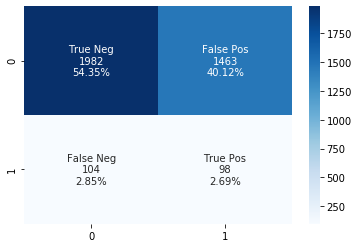

In [45]:
#Base model KNN Confusion Matrix
knndown_cf_matrix_base = confusion_matrix(y_test, knndown_pred)
#heatmap Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                knndown_cf_matrix_base.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     knndown_cf_matrix_base.flatten()/np.sum(knndown_cf_matrix_base)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(knndown_cf_matrix_base, annot=labels, fmt='', cmap='Blues')

5.4.4 Gradient Boosting Base Model

In [46]:
gb_down.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

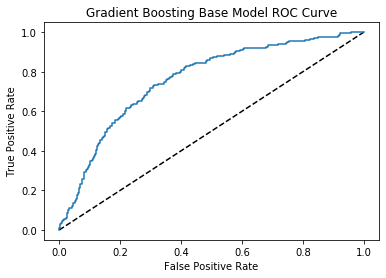

In [47]:
#ROC curve for Gradient Boosting Base Model

from sklearn.metrics import roc_curve 
y_gbdown_pred_prob = gb_down.predict_proba(X_test)[:,1] 
fpr, tpr, thresholds = roc_curve(y_test, y_gbdown_pred_prob) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.plot(fpr, tpr, label='Logistic Regression') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Gradient Boosting Base Model ROC Curve') 
plt.show(); 

In [48]:
#Area under the curve

from sklearn.metrics import roc_auc_score 
roc_auc_score(y_test, y_gbdown_pred_prob)

0.7588828694190174

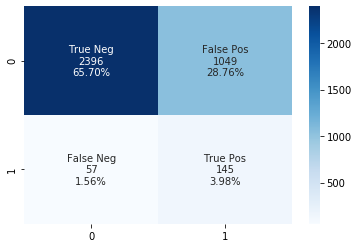

In [49]:
#Base model GB Confusion Matrix
gbdown_cf_matrix_base = confusion_matrix(y_test, gbdown_pred)
#heatmap Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                gbdown_cf_matrix_base.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     gbdown_cf_matrix_base.flatten()/np.sum(gbdown_cf_matrix_base)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(gbdown_cf_matrix_base, annot=labels, fmt='', cmap='Blues')

5.4.5 Support Vector Machine Base Model

In [50]:
svc_down.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

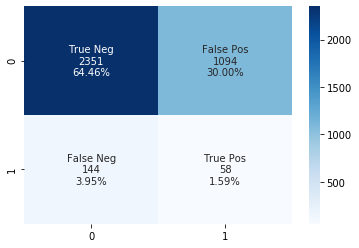

In [51]:
#Base model SVC Confusion Matrix
svcdown_cf_matrix_base = confusion_matrix(y_test, svcdown_pred)
#heatmap Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                svcdown_cf_matrix_base.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     svcdown_cf_matrix_base.flatten()/np.sum(svcdown_cf_matrix_base)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(svcdown_cf_matrix_base, annot=labels, fmt='', cmap='Blues')

# 5.5 Comparing the Models

We will compute the components of confusion matrix for each model

In [52]:
lrdown_tn = tn(y_test,lrdown_pred)
lrdown_fn = fn(y_test,lrdown_pred)
lrdown_tp = tp(y_test,lrdown_pred)
lrdown_fp = fp(y_test,lrdown_pred)

rfdown_tn = tn(y_test,rfdown_pred)
rfdown_fn = fn(y_test,rfdown_pred)
rfdown_tp = tp(y_test,rfdown_pred)
rfdown_fp = fp(y_test,rfdown_pred)

knndown_tn = tn(y_test,knndown_pred)
knndown_fn = fn(y_test,knndown_pred)
knndown_tp = tp(y_test,knndown_pred)
knndown_fp = fp(y_test,knndown_pred)

gbdown_tn = tn(y_test,gbdown_pred)
gbdown_fn = fn(y_test,gbdown_pred)
gbdown_tp = tp(y_test,gbdown_pred)
gbdown_fp = fp(y_test,gbdown_pred)

svcdown_tn = tn(y_test,svcdown_pred)
svcdown_fn = fn(y_test,svcdown_pred)
svcdown_tp = tp(y_test,svcdown_pred)
svcdown_fp = fp(y_test,svcdown_pred)

With the computed scores in confusion matrix, we will put True Positive (red) and False Negative (pink) stacking together on a bar. We will use this visualization to compare our base models. It appears that Random Forest and Gradient Boosting perform better than the other base models.

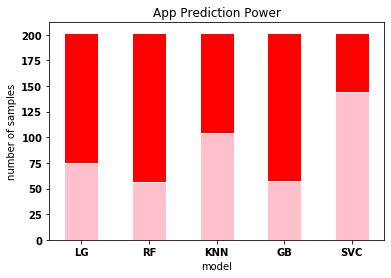

In [53]:
#plotting barplot for the fraud detection
from matplotlib import rc

# y-axis in bold
rc('font', weight='bold')

# Values of each group
#bars1 = [lrup_tn, rfup_tn, knnup_tn, gbup_tn]
bars2 = [lrdown_fn, rfdown_fn, knndown_fn, gbdown_fn, svcdown_fn]
bars3 = [lrdown_tp, rfdown_tp, knndown_tp, gbdown_tp, svcdown_tp]
#bars4 = [lrup_fn, rfup_fn, knnup_fn, gbup_fn]


# Heights of bars1 + bars2
#bars12 = np.add(bars1, bars2).tolist()
# Heights of bars1 + bars2 + bars3
#bars123 = np.add(bars12, bars3).tolist()

# The position of the bars on the x-axis
r = [0,2,4,6,8]

# Names of group and bar width
names = ['LG','RF','KNN','GB','SVC']
barWidth = 1

# Create brown bars
plt.bar(r, bars2, color='pink', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars3, bottom=bars2, color='red', edgecolor='white', width=barWidth)
# Create green bars (top)
#plt.bar(r, bars3, bottom=bars12, color='orange', edgecolor='white', width=barWidth)
#plt.bar(r, bars4, bottom=bars123, color='red', edgecolor='white', width=barWidth)

# Custom X axis
plt.title('App Prediction Power')
plt.xticks(r, names, fontweight='bold')
plt.xlabel("model")
plt.ylabel('number of samples')

plt.show()

Next, we will stack True Negative and False Positive on the same bar for each algorithm. It appears that the KNN model has the lowest performance in this criteria.

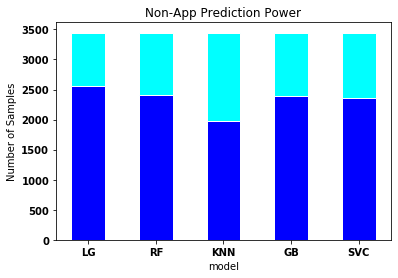

In [54]:
#plotting barplot for the confusion matrix
from matplotlib import rc

# y-axis in bold
rc('font', weight='bold')

# Values of each group
bars1 = [lrdown_tn, rfdown_tn, knndown_tn, gbdown_tn, svcdown_tn]
bars2 = [lrdown_fn, rfdown_fn, knndown_fn, gbdown_fn, svcdown_fn]
bars3 = [lrdown_tp, rfdown_tp, knndown_tp, gbdown_tp, svcdown_tp]
bars4 = [lrdown_fp, rfdown_fp, knndown_fp, gbdown_fp, svcdown_fp]


# Heights of bars1 + bars2
bars12 = np.add(bars1, bars2).tolist()
# Heights of bars1 + bars2 + bars3
bars123 = np.add(bars12, bars3).tolist()

# The position of the bars on the x-axis
r = [0,2,4,6,8]

# Names of group and bar width
names = ['LG','RF','KNN','GB','SVC']
barWidth = 1

# Create brown bars
plt.bar(r, bars1, color='blue', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
#plt.bar(r, bars2, bottom=bars1, color='pink', edgecolor='white', width=barWidth)
# Create green bars (top)
#plt.bar(r, bars3, bottom=bars12, color='red', edgecolor='white', width=barWidth)
plt.bar(r, bars4, bottom=bars1, color='cyan', edgecolor='white', width=barWidth)

# Custom X axis
plt.title('Non-App Prediction Power')
plt.xticks(r, names, fontweight='bold')
plt.xlabel("model")
plt.ylabel('Number of Samples')

plt.show()

So far, we observed that Random Forest and Gradient Boosting appear to perform better with the above visualized evaluations. Next, we will let the base model predict the test set.

Testing with testset

In [55]:
#making predictions
lrdown_pred = lr_down.predict(X_test)
rfdown_pred = rf_down.predict(X_test)
knndown_pred= knn_down.predict(X_test)
gbdown_pred= gb_down.predict(X_test)
svcdown_pred= svc_down.predict(X_test)

As we aim for the recall score (how often we predict the true postive), we will pull that score from the testing set to evaluate further. It looks like Random Forest has the highest recall score.

In [56]:
print('Logistic Regression Recall Score:',recall_score(y_test,lrdown_pred))
print('Random Forest Recall Score:',recall_score(y_test,rfdown_pred))
print('KNN Recall Score:',recall_score(y_test,knndown_pred))
print('Gradient Boosting Recall Score:',recall_score(y_test,gbdown_pred))
print('Support Vector Machine Recall Score:',recall_score(y_test,svcdown_pred))

Logistic Regression Recall Score: 0.6287128712871287
Random Forest Recall Score: 0.7227722772277227
KNN Recall Score: 0.48514851485148514
Gradient Boosting Recall Score: 0.7178217821782178
Support Vector Machine Recall Score: 0.2871287128712871


We will also pull the feature importances for the highest performers Random Forest and Gradient Boosting. We can see similar features significantly affecting the prediction of outcome 'app'.

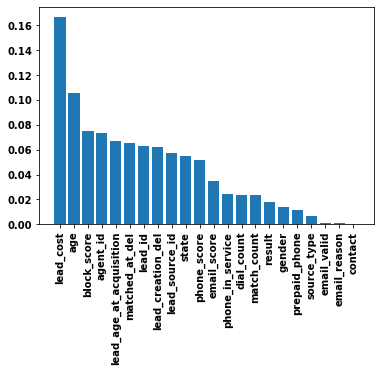

In [57]:
#Feature Importance of RF
importances_rf = rf_down.feature_importances_

# index of greatest to least feature importances
sorted_index = np.argsort(importances_rf)[::-1]
x = range(len(importances_rf))
# create tick labels
feature_names = Xd_train.columns
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances_rf[sorted_index], tick_label=labels)
# rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

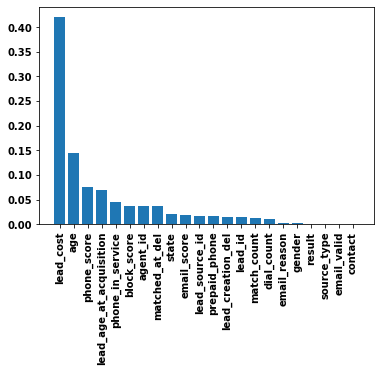

In [58]:
#Feature Importance of GB
importances_gb = gb_down.feature_importances_

# index of greatest to least feature importances
sorted_index = np.argsort(importances_gb)[::-1]
x = range(len(importances_gb))
# create tick labels
feature_names = Xd_train.columns
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances_gb[sorted_index], tick_label=labels)
# rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

# Tuning Random Forest Model

With the above evalauation, we will choose Random Forest to tune. The base Random Forest model yields a recall score of 0.73. We will use Parameter Grid to perform tune the hyperparameters. The tuned model seems to perform better with an improved recall score of 0.76

In [59]:
from sklearn.model_selection import ParameterGrid

#Featuring the RF Model
rf_down_featured = RandomForestClassifier()

#Tuning Parameters for RF base model
# Create Parameter Space
n_estimators = [40,50,75,85,95,105,125, 200, 250]
max_depth = [10,12,13,14,15,17,20]
max_features = [3,4,5,6,8,10,12,14,17]
# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
rfdown_parameters = dict(n_estimators = n_estimators,max_depth = max_depth, max_features = max_features)

 #Tuning Hyperparameters for LG Models
test_recall_scores_rfdown = []
# loop through the parameter grid, set hyperparameters, save the scores
for g in ParameterGrid(rfdown_parameters):
    rf_down_featured.set_params(**g) # ** is "unpacking" the dictionary
    rfdown_cv_results_tuned = cross_validate(rf_down_featured.fit(Xd_train, yd_train), Xd_train, yd_train, cv=5, scoring=scoring)
    test_recall_scores_rfdown.append(rfdown_cv_results_tuned['test_rc'].mean())
# find best hyperparameters from the test score and print
best_idx_rfdown = np.argmax(test_recall_scores_rfdown)
print(test_recall_scores_rfdown[best_idx_rfdown])
print(ParameterGrid(rfdown_parameters)[best_idx_rfdown])

0.7580707000996856
{'n_estimators': 50, 'max_features': 6, 'max_depth': 10}


To ensure this improvement, we will use the tuned model against the test set. It also yield an improved recall score of 0.76. However, we observe a great number of false positive too. 

In [60]:
#Tuned RF model
rf_down_tuned = RandomForestClassifier()
rf_down_tuned.set_params(**ParameterGrid(rfdown_parameters)[best_idx_rfdown])

#Fitting the model with tuned parameters and print the recall score
rf_down_tuned.fit(Xd_train,yd_train)
rf_down_tuned_pred = rf_down_tuned.predict(X_test)
print('Tested RF recall score:',recall_score(y_test,rf_down_tuned_pred))

#Random Forest Confusion Matrix
rfdown_cf_matrix = confusion_matrix(y_test, rf_down_tuned_pred)
print(rfdown_cf_matrix)

Tested RF recall score: 0.7475247524752475
[[2363 1082]
 [  51  151]]


In [61]:
rf_down_tuned.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 6,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

When we downsampled, the original training set was reduced. Therefore, there are records that the model has not seem yet. We let the model run against this set. As a similar result to above, we see good true postive and misclassfition reflected by false postive score.

In [62]:
#Check how the model predicts for the original big dataset

#label encoder
def convert_4(data):
    for column in X_train.columns:
        if X_train[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            X_train[column] = le.fit_transform(X_train[column])
            
convert_4(X_train)

#run prediction agaist the original test set
rf_down_tuned_predo = rf_down_tuned.predict(X_train)
rfdown_cf_matrix_all = confusion_matrix(y_train, rf_down_tuned_predo)
print(rfdown_cf_matrix_all)

[[9571 4209]
 [  34  772]]


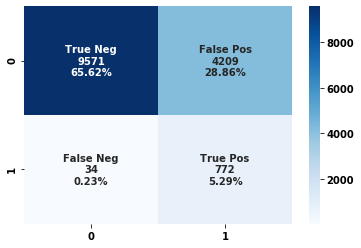

In [63]:
#heatmap Confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                rfdown_cf_matrix_all.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     rfdown_cf_matrix_all.flatten()/np.sum(rfdown_cf_matrix_all)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(rfdown_cf_matrix_all, annot=labels, fmt='', cmap='Blues')

We will use the predict_proba function to populate the probability of our predictions. From there, we can adjust the probability to see if we can minimize the misclassification resulted by the tuned model

In [64]:
#populate the preidcted outcome 'RF Pred' as a column and export into a .csv file.
tested_predictions = pd.concat([X_test,y_test],axis=1)
tested_predictions['RF Pred']=rf_down_tuned_pred
tested_apps = tested_predictions[tested_predictions['app']==1]
tested_non_apps = tested_predictions[tested_predictions['app']==0]
tested_apps.to_csv('tested results', index = False)


#populate the probability of app = 1 as a column and export the result to .csv file
rf_down_tuned_pred_proba = rf_down_tuned.predict_proba(X_test)[:,1]
tested_predictions['RF Pred Prob']=rf_down_tuned_pred_proba
tested_apps_2 = tested_predictions[tested_predictions['app']==1]
tested_apps_2.to_csv('tested results 2', index = False)
tested_non_apps_2 = tested_predictions[tested_predictions['app']==0]
tested_non_apps_2.to_csv('tested results 2', index = False)


As we reduce the probability, we observe improvement for both True Postive (more correct predictions) and False Positve (less incorrect predictions). The trade-off here is that we will have to live with the low probability. In this attempt below,we observe the number of misclassfication for application and non-application with a probability of 0.2

In [65]:
#number of misclassified app for propability 0f 0.2
np.count_nonzero(tested_apps_2['RF Pred Prob'] < 0.2)

11

In [66]:
#number of misclassified non-app for propability of 0.2
np.count_nonzero(tested_non_apps_2['RF Pred Prob'] < 0.2)

941

# 6. Deployment

Now with the Random Forest model, we will deploy it to populate our predictions for the unconatcted leads. With the outcome, we will see which lead possibly convert to application with what probability.

First, we will need to process the uncontacted leads data. This will include label encoder and splitting the set into X, which has the predictors, and y which is the target. 

In [67]:
uncontacted_df = match_df[match_df['contact'] == 0]

#label encoder
def convert_5(data):
    for column in uncontacted_df.columns:
        if uncontacted_df[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            uncontacted_df[column] = le.fit_transform(uncontacted_df[column])
            
convert_5(uncontacted_df)

#splitting the data into X and y format to feed the model
uncontacted_df['app']=uncontacted_df['app']+1
uncontacted_X = uncontacted_df.drop('app',axis=1)
uncontacted_y = uncontacted_df['app']

uncontacted_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19659 entries, 83148 to 57802
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   lead_id                  19659 non-null  int64  
 1   agent_id                 19659 non-null  int64  
 2   lead_source_id           19659 non-null  int64  
 3   dial_count               19659 non-null  int64  
 4   source_type              19659 non-null  int32  
 5   state                    19659 non-null  int32  
 6   gender                   19659 non-null  int32  
 7   age                      19659 non-null  int64  
 8   lead_cost                19659 non-null  float64
 9   result                   19659 non-null  float64
 10  lead_age_at_acquisition  19659 non-null  float64
 11  prepaid_phone            19659 non-null  int32  
 12  phone_in_service         19659 non-null  int32  
 13  email_score              19659 non-null  float64
 14  email_valid       

C:\Users\17138\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\17138\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Now, we will make prediction for these uncontacted leads. In addition to the uncontacted_df columns, we will add a new one 'RF Pred app' to populate our prediction result (1=app, 0= non-app). We will also populate the probability of our predictions. The 'RF Pre Prob Non-App' column will populate the propability for leads predicted to not convert to applications. The '1-RF Pred Prob app' will populate probability for leads predicted to convert to applications.

In [68]:
rf_down_tuned_pred_deploy = rf_down_tuned.predict(uncontacted_X)
deployed_rf_down_tuned_pred_proba = rf_down_tuned.predict_proba(uncontacted_X)
predicted_y = rf_down_tuned_pred_deploy
deployed_predictions = uncontacted_df
#populate prediction outcome
deployed_predictions['RF Pred app']=predicted_y
#populate probability for predicted non-app
deployed_predictions['RF Pred Prob Non-App']= deployed_rf_down_tuned_pred_proba[:,0]
#populate probability for predicted app
deployed_predictions['1-RF Pred Prob App']= deployed_rf_down_tuned_pred_proba[:,1]
deployed_apps = deployed_predictions[deployed_predictions['RF Pred app']==1]
deployed_non_apps = deployed_predictions[deployed_predictions['RF Pred app']==0]
#export the result to .csv
deployed_apps.to_csv('deployed app', index = False)
deployed_predictions.to_csv('deployed results', index = False)


C:\Users\17138\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\17138\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\17138\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

With the populated predictions, the business operation can prioritize to target leads with high probability to convert to applications. The agent can start reaching out to the clients who are more likely to appliy for the insurance. 

# 7. Feedback

- The developer of this model will need valuable feedback from analytics teams for code review. Additional opinion from subject matter expoerts in insurance industry will also be considered to determine if the model really makes any sense.

- The deployed model will need to get feedback from business operation. That way, we will know if the model actually help improve maximizing the sales or not. 

- With the feedback, we can determine if additional steps are needed for the model. The steps could be collecting more data or modifying the model with some different techniques.

# 8. Plan for The Next Steps

- There are some further steps to consider to possibly improve the current model,

    > A train:test split ratio of 4:1 was used to separate the data. We can also try different ratios to see if we can observe any better prediction.
    
    > We will also need inputs from business operation to determine a reasonable probability to set for the model. In this experiment, the probability was tested to 0.2. This could be a high uncertainty for the business. Understanding how it affect the sales will be helpful to construct a reasonable prediction.
    
- We can also try other resampling techniques like oversampling, GAN, etc. to see if we can get more data to train for a better model.

- Some other good base models we observed earlier are Gradient Boosting and Support Vector Machine. We can try tuning them to see if the result would be any better than Random Forest.

- Feedback from business operation will be very helpful. In addition to assiting in collecting more data, the feedback may help determine if we should create some new features to improve the prediction. In this experiement, a new feature call 'match_count' was created but it was purposed for dropping the duplicate matches associated with a leads. More meaningful feature might be developed from the existing columns to yield a better prediction.

- We can also design an A/B test to evalauate this model versus soem other competative model. From there, we can make decision to deploy the best technique